In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

## **Load preprocessed data**

In [3]:
root_dir = "/content/drive/MyDrive/disastertweet"
data_dir = "/content/drive/MyDrive/disastertweet/data"
checkpoint_dir = root_dir + '/checkpoint'

In [4]:
data = pd.read_csv(data_dir + '/train_processed.csv', index_col = None)
data.head()

,Unnamed: 0,id,keyword,location,text,target,cleaned,text_len_cleaned
0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv,6
1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near rong sask canada,6
2,2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,11
3,3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv fire wildfir evacu order california,7
4,4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke fire wildfir ...,10


In [5]:
data_cleaned = data['cleaned']
data_cleaned

0                  deed reason earthquak may allah forgiv
1                       forest fire near rong sask canada
2       resid ask shelter place notifi offic evacu she...
3        peopl receiv fire wildfir evacu order california
4       got sent photo rubi alaska smoke fire wildfir ...
                              ...                        
7608        two giant crane hold bridg collap nearbi home
7609    aria ahrari thetawniest control wild fire cali...
7610                                       volcano hawaii
7611    polic investig ebik collid car littl portug eb...
7612    latest home raze northern california fire wild...
Name: cleaned, Length: 7613, dtype: object

In [6]:
label = data['target']
label

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [7]:
X = data_cleaned.to_numpy()
X = [str(x) for x in X]
print(X[:10])
y = label.to_numpy()
print(y[:10])
print(type(y[0]))

['deed reason earthquak may allah forgiv', 'forest fire near rong sask canada', 'resid ask shelter place notifi offic evacu shelter place order expect', 'peopl receiv fire wildfir evacu order california', 'got sent photo rubi alaska smoke fire wildfir pour school', 'fire updat california hwi close direct due lake counti fire fire fire wildfir', 'flood disast heavi rain caus flash flood street manitou colorado spring area', 'top hill see fire wood', 'there emerg evacu happen build across street', 'afraid tornado come area']
[1 1 1 1 1 1 1 1 1 1]
<class 'numpy.int64'>


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle = True)
print(len(X_train))
print(len(X_test))


5709
1904


In [9]:
# Find max-length of a tweet
max_length_seq = max([len(x.split(" ")) for x in X if isinstance(x,str)])
print(max_length_seq)

21


In [10]:
# Find number of unique words
unique_words = set()

# Tokenize and add unique words to the set
for sentence in X:
    if isinstance(sentence, str):
        words = sentence.split(" ")
    else:
        words = 'nan'
    unique_words.update(words)

# Get the number of unique words
num_unique_words = len(unique_words)
print(num_unique_words)

13201


In [11]:
# Create text-vectorize object
max_vocab_length = 13000 # max number of words to have in our vocabulary

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length_seq)

In [12]:
text_vectorizer.adapt(X)

In [13]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 21), dtype=int64, numpy=
array([[  1,   1,  17,   1, 772, 399,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]])>

In [14]:
# X_train, X_test for normal-embedding
X_train_nor = np.array(text_vectorizer(X_train))
X_test_nor =  np.array(text_vectorizer(X_test))

In [15]:
type(X_train_nor)

numpy.ndarray

In [16]:
# 1) Create embedding layers randomly in uniform distribution
tf.random.set_seed(42)
embedding_normal = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length_seq,
                             name="embedding_1")

embedding_normal

In [17]:
# 2) Create pre-trained GLove embedding
tokenizer = Tokenizer(num_words=max_vocab_length, oov_token = True)
tokenizer.fit_on_texts(X)
# X_train, X_test for GLove tokenizer
X_train_glove = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length_seq)
X_test_glove  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length_seq)

In [18]:
X_train_glove[:10]

array([[    0,     0,     0,     0,     0,     0, 10740, 10741,    39,
         1017,  2117,   914,   626,  2117,    41,  1753,  1753,  1229,
          466,    85,   626],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0, 11923,    62,  3239,   309, 11924,
          239,  2185,  2047],
       [    0,     0,     0,     0,     0,   224,  8824,  3848,  1303,
           80,   114,  1037,   421,   375,    29,     3,   246,    64,
           66,     9,    11],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    70,  1357,
          298,    70,   443],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,   155,   234,    20,
          100,   178,   573],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,  1198, 10761,   279,  1294,  1578,  1194,   640,    85

In [19]:
len(tokenizer.index_word)

13202

In [20]:
# Pretrained GLove embedding
glove_txt = root_dir + '/glove.6B.100d.txt'
def create_glove_vocab():
  glove_file = open(glove_txt)
  em_dictionary = {}
  for line in glove_file:
      records = line.split()
      word = records[0]
      vector_dimensions = np.asarray(records[1:], dtype='float32')
      em_dictionary[word] = vector_dimensions
  glove_file.close()
  return em_dictionary

def create_glove_embedding_matrix(em_dict, em_dim = 100):
    vocab_size = len(tokenizer.index_word) + 1
    print("Vocab_size", vocab_size)
    embedding_matrix = np.zeros((vocab_size, em_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = em_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [21]:
em_dict = create_glove_vocab()
em_matrix = create_glove_embedding_matrix(em_dict)

Vocab_size 13203


In [22]:
em_matrix.shape

(13203, 100)

In [23]:
# Glove embedding layers
glove_embed = layers.Embedding(input_dim=em_matrix.shape[0], output_dim=em_matrix.shape[1],
                              input_length=max_length_seq, trainable=False, weights=[em_matrix])


## Create model

In [24]:
def define_callback(model_name):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    model_dir = checkpoint_dir + '/{}'.format(model_name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=3, verbose= 1)

    checkpoint= tf.keras.callbacks.ModelCheckpoint(
    filepath= model_dir + '/{}.hdf5'.format(model_name),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = 1)
    return early_stopping_callback, checkpoint

In [25]:
def get_classfication_report(y_pred, y_true):
    return classification_report(y_true, y_pred)

In [26]:
def get_cfm(y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [27]:
def get_class(model, X_test):
    pred = model.predict(X_test)
    pred = [1 if i >= 0.5 else 0 for i in pred]
    return pred

### **Model 1: MLP Dense model**

In [28]:
def get_model1(glove_embedding = False):
    model_name = 'model1_mlp'
    inputs = layers.Input(shape = (1, ))
    if glove_embedding:
      x = glove_embed(inputs)
      model_name = 'model1_mlp_glove'
    else:
      x = embedding_normal(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model_1 = tf.keras.Model(inputs, outputs, name= model_name)
    model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

    # Get callback
    early_stop, cp1 = define_callback(model_name)
    print(model_1.summary())
    return model_1, early_stop, cp1

In [29]:
# Model 1: GLove_embedding = False
model_1,early, cp1 = get_model1()

Model: "model1_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 1, 128)            1664000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,664,129
Trainable params: 1,664,129
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
model1_history = model_1.fit(X_train_nor, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              y_train,
                              epochs=10,
                              callbacks = [early, cp1],
                              validation_data=(X_test_nor, y_test))

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.6541 - accuracy: 0.6024
Epoch 1: val_accuracy improved from -inf to 0.72006, saving model to /content/drive/MyDrive/disastertweet/checkpoint/model1_mlp/model1_mlp.hdf5
179/179 [==============================] - 21s 88ms/step - loss: 0.6541 - accuracy: 0.6024 - val_loss: 0.6088 - val_accuracy: 0.7201
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 0.5234 - accuracy: 0.7895
Epoch 2: val_accuracy improved from 0.72006 to 0.80462, saving model to /content/drive/MyDrive/disastertweet/checkpoint/model1_mlp/model1_mlp.hdf5
179/179 [==============================] - 4s 23ms/step - loss: 0.5234 - accuracy: 0.7895 - val_loss: 0.4924 - val_accuracy: 0.8046
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.3963 - accuracy: 0.8543
Epoch 3: val_accuracy improved from 0.80462 to 0.81250, saving model to /content/drive/MyDrive/disastertweet/checkpoint/model1_mlp/model1_mlp.hdf5
179/179 [

In [31]:
model_1_pred = get_class(model_1, X_test_nor)

60/60 [==============================] - 0s 1ms/step


In [32]:
get_classfication_report(model_1_pred, y_test)

'              precision    recall  f1-score   support\n\n           0       0.81      0.85      0.83      1091\n           1       0.79      0.72      0.75       813\n\n    accuracy                           0.80      1904\n   macro avg       0.80      0.79      0.79      1904\nweighted avg       0.80      0.80      0.80      1904\n'

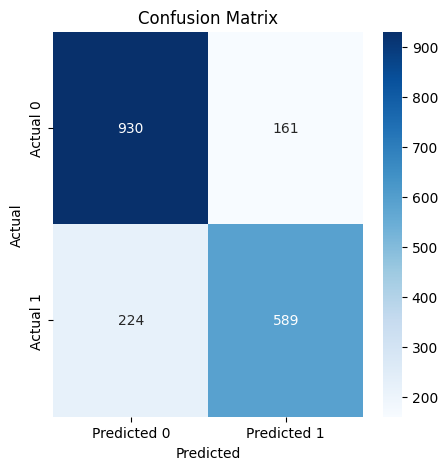

In [33]:
get_cfm(model_1_pred, y_test)

In [34]:
# Model1: glove-embedding = True
model1_glo, early_glo, cp = get_model1(glove_embedding = True)
model1_glo.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model1_glo_history = model1_glo.fit(X_train_glove, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              y_train,
                              epochs=10,
                              callbacks = [early_glo, cp],
                              validation_data=(X_test_glove, y_test))

Model: "model1_mlp_glove"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding (Embedding)       (None, 1, 100)            1320300   
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,320,401
Trainable params: 101
Non-trainable params: 1,320,300
_________________________________________________________________
None
Epoch 1/10
172/179 [===========================>..] - ETA: 0s - loss: 0.6668 - accuracy: 0.6195
Epo

60/60 [==============================] - 0s 1ms/step


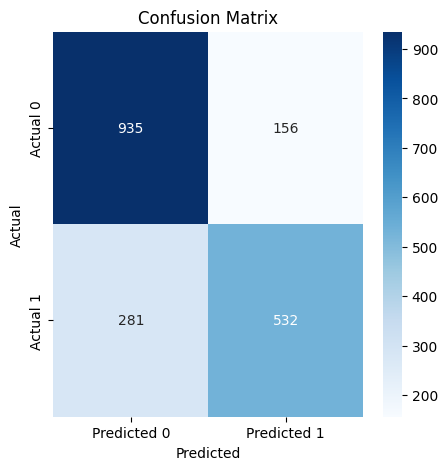

In [35]:
model_1_glo_pred = get_class(model1_glo, X_test_glove)
get_cfm(model_1_glo_pred, y_test)

#### **Model 2: LSTM-Bi-LSTM**

In [36]:
def get_model2(glove_embedding = False, bidirectional = False):
    name = {(False, False): "00", (False, True): "01", (True, False): "10", (True, True): "11"}
    inputs = layers.Input(shape=(1,))
    if glove_embedding:
      x = glove_embed(inputs)
    else:
      x = embedding_normal(inputs)
    if bidirectional:
      x = layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
      x = layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
    else:
      x = layers.LSTM(64, return_sequences=True)(x)
      x = layers.LSTM(32)(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model_name = name[(glove_embedding, bidirectional)]
    model_2 = tf.keras.Model(inputs, outputs, name= "model2_" + model_name)
    model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

    # Get callback
    early_stop, cp = define_callback("model2_" + model_name)
    print(model_2.summary())
    return model_2, early_stop, cp

In [37]:
# Model2: Glove = False, bidirectional = False
model_2, early, cp= get_model2(glove_embedding = False, bidirectional = False)

Model: "model2_00"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 1, 128)            1664000   
                                                                 
 lstm (LSTM)                 (None, 1, 64)             49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,726,913
Trainable params: 1,726,913
Non-t

In [38]:
model2_history= model_2.fit(X_train_nor,
                              y_train,
                              epochs=5,
                              callbacks = [early, cp],
                              validation_data=(X_test_nor, y_test))

Epoch 1/5
179/179 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9445
Epoch 1: val_accuracy improved from -inf to 0.78519, saving model to /content/drive/MyDrive/disastertweet/checkpoint/model2_00/model2_00.hdf5
179/179 [==============================] - 21s 90ms/step - loss: 0.2022 - accuracy: 0.9445 - val_loss: 0.6042 - val_accuracy: 0.7852
Epoch 2/5
179/179 [==============================] - ETA: 0s - loss: 0.1173 - accuracy: 0.9574
Epoch 2: val_accuracy improved from 0.78519 to 0.78992, saving model to /content/drive/MyDrive/disastertweet/checkpoint/model2_00/model2_00.hdf5
179/179 [==============================] - 4s 21ms/step - loss: 0.1173 - accuracy: 0.9574 - val_loss: 0.5983 - val_accuracy: 0.7899
Epoch 3/5
179/179 [==============================] - ETA: 0s - loss: 0.0936 - accuracy: 0.9639
Epoch 3: val_accuracy did not improve from 0.78992
179/179 [==============================] - 3s 14ms/step - loss: 0.0936 - accuracy: 0.9639 - val_loss: 0.7333 - v

In [39]:
# model2.2 - glove = True, bidirectional = False
model2_2, early, cp = get_model2(glove_embedding = True, bidirectional = False)
model2_2_history= model2_2.fit(X_train_glove,
                              y_train,
                              epochs=10,
                              callbacks = [early, cp],
                              validation_data=(X_test_glove, y_test))

Model: "model2_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding (Embedding)       (None, 1, 100)            1320300   
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             42240     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,376,045
Trainable params: 55,745
Non-trai

In [40]:
# model 2_3: glove_em = False, bidirect = True
model2_3, early, cp= get_model2(glove_embedding = False, bidirectional = True)
model2_3_history= model2_3.fit(X_train_nor,
                              y_train,
                              epochs=5,
                              callbacks = [early, cp],
                              validation_data=(X_test_nor, y_test))

Model: "model2_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 1, 128)            1664000   
                                                                 
 bidirectional (Bidirectiona  (None, 1, 128)           98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33

In [41]:
# model_2_4: glove_em = True, bidirect = True
model2_4, early, cp = get_model2(glove_embedding = True, bidirectional = True)
model2_4_history= model2_4.fit(X_train_glove,
                              y_train,
                              epochs=10,
                              callbacks = [early, cp],
                              validation_data=(X_test_glove, y_test))

Model: "model2_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding (Embedding)       (None, 1, 100)            1320300   
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 128)           84480     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33

### **Model 3: TensorHub pretrained Universal Sentence Encoder**

In [42]:
import tensorflow_hub as hub

In [43]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights
                                        name="hub-embed")

In [44]:
sentence_encoder_layer

In [45]:
def get_model3():
  model_3 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")], name = 'tf-hub-model')


  # Compile model
  model_3.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
  # Compile model
  early_stop, cp = define_callback('tfhub')
  return model_3, early_stop, cp


In [46]:
model_3, early, cp = get_model3()

In [47]:
model_3_history = model_3.fit(np.array(X_train),
                              y_train,
                              epochs=15,
                              validation_data=(np.array(X_test), y_test),
                              callbacks=[early, cp])

Epoch 1/15
176/179 [============================>.] - ETA: 0s - loss: 0.5671 - accuracy: 0.7349
Epoch 1: val_accuracy improved from -inf to 0.78151, saving model to /content/drive/MyDrive/disastertweet/checkpoint/tfhub/tfhub.hdf5
179/179 [==============================] - 43s 209ms/step - loss: 0.5656 - accuracy: 0.7359 - val_loss: 0.4950 - val_accuracy: 0.7815
Epoch 2/15
175/179 [============================>.] - ETA: 0s - loss: 0.4776 - accuracy: 0.7852
Epoch 2: val_accuracy improved from 0.78151 to 0.78361, saving model to /content/drive/MyDrive/disastertweet/checkpoint/tfhub/tfhub.hdf5
179/179 [==============================] - 8s 47ms/step - loss: 0.4784 - accuracy: 0.7847 - val_loss: 0.4842 - val_accuracy: 0.7836
Epoch 3/15
179/179 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.7884
Epoch 3: val_accuracy improved from 0.78361 to 0.78466, saving model to /content/drive/MyDrive/disastertweet/checkpoint/tfhub/tfhub.hdf5
179/179 [=============================

### **Model 4: CONV1D**

In [102]:
def get_model4(glove_embedding = False):
    inputs = layers.Input(shape=(1,))
    model_name = 'model4'
    if glove_embedding:
      x = glove_embed(inputs)
      model_name = 'model4_glove'
    else:
      x = embedding_normal(inputs)
    x = layers.Conv1D(filters=32, kernel_size=5, activation="relu", padding="same")(x)
    x = layers.GlobalMaxPool1D()(x)

    # x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model_4 = tf.keras.Model(inputs, outputs, name=model_name)

    # Compile Conv1D model
    model_4.compile(loss="binary_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

    model_4.summary()
    early, cp = define_callback(model_name)
    return model_4, early, cp

In [103]:
model_4, early, cp = get_model4()

Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 1, 128)            1664000   
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 32)             20512     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_25 (Dense)            (None, 32)                1056      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                            

In [104]:
model_4_history = model_4.fit(X_train_nor,
                              y_train,
                              epochs=10,
                              validation_data=(X_test_nor, y_test),
                              callbacks=[early, cp])

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9758
Epoch 1: val_accuracy improved from -inf to 0.76103, saving model to /content/drive/MyDrive/disastertweet/checkpoint/model4/model4.hdf5
179/179 [==============================] - 14s 73ms/step - loss: 0.0919 - accuracy: 0.9758 - val_loss: 0.9681 - val_accuracy: 0.7610
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 0.0426 - accuracy: 0.9821
Epoch 2: val_accuracy improved from 0.76103 to 0.76155, saving model to /content/drive/MyDrive/disastertweet/checkpoint/model4/model4.hdf5
179/179 [==============================] - 4s 19ms/step - loss: 0.0426 - accuracy: 0.9821 - val_loss: 1.0454 - val_accuracy: 0.7616
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9839
Epoch 3: val_accuracy did not improve from 0.76155
179/179 [==============================] - 3s 17ms/step - loss: 0.0368 - accuracy: 0.9839 - val_loss: 1.1212 - val_accura

In [107]:
# model4;Glove = True
model4_1, early, cp = get_model4(glove_embedding = True)
model4_1_history = model4_1.fit(X_train_glove,
                              y_train,
                              epochs=10,
                              validation_data=(X_test_glove, y_test),
                              callbacks=[early, cp])

Model: "model4_glove"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1)]               0         
                                                                 
 embedding (Embedding)       (None, 1, 100)            1320300   
                                                                 
 conv1d_10 (Conv1D)          (None, 1, 32)             16032     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_31 (Dense)            (None, 32)                1056      
                                                                 
 dense_32 (Dense)            (None, 1)                 33        
                                                      